In [12]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    #'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [13]:
def read_logfile(logfile_name):
    all_values = []
    value_labels = ['num_attention_heads', 'hidden_size', 'train_micro_batch_size_per_gpu',
                    'tensor_mp_size', 'pipeline_mp_size', 'dp_size',]
    with open(logfile_name, 'r') as f:
        reading_estimate = False
        for line in f:
            line = line.strip()
            if line == "Estimate":
                reading_estimate = True
            elif line == "Actual":
                reading_estimate = False
            match = re.match(r'num_attention_heads: (\d+), hidden_size: (\d+), '
                             r'train_micro_batch_size_per_gpu: (\d+), tensor_mp_size: (\d+), '
                             r'pipeline_mp_size: (\d+), dp_size: (\d+)', line)
            if match is not None:
                values = {}
                for i in range(1, 7):
                    values[value_labels[i-1]] = int(match.group(i))
                all_values.append(values)

            match = re.match(r'num_attention_heads: (\d+), hidden_size: (\d+), '
                             r'microbatch_size: (\d+), tensor_mp_size: (\d+), '
                             r'pipeline_mp_size: (\d+), dp_size: (\d+)', line)
                             
            if match is not None:
                values = {}
                for i in range(1, 7):
                    values[value_labels[i-1]] = int(match.group(i))
                all_values.append(values)

            match = re.match(r'Throughput \(in TFLOP/s\) for attention_key_value_query_transform \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_key_value_query_transform"] = throughput
            
            match = re.match(r'Throughput \(in TFLOP/s\) for attention_key_query_prob \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_key_query_prob"] = throughput

            match = re.match(r'Throughput \(in TFLOP/s\) for attention_prob_times_values \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_prob_times_values"] = throughput
            
            match = re.match(r'Throughput \(in TFLOP/s\) for attention_linear_projection \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_linear_projection"] = throughput 

            match = re.match(r'Throughput \(in TFLOP/s\) for mlp_h_to_4h \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["mlp_h_to_4h"] = throughput  

            match = re.match(r'Throughput \(in TFLOP/s\) for mlp_4h_to_h \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["mlp_4h_to_h"] = throughput 
                
            match = re.match(r'Attention throughput \(in TFLOP/s\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_attention_throughput"] = throughput
                else:
                   all_values[-1]["actual_attention_throughput"] = throughput 

            match = re.match(r'Transformer duration \(in seconds\): (\d+\.\d+)', line)
            if match is not None:
                duration = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_duration"] = duration
                else:
                    all_values[-1]["actual_duration"] = duration
            match = re.match(r'Transformer throughput \(in TFLOP/s\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_throughput"] = throughput
                else:
                    all_values[-1]["actual_throughput"] = throughput
    return all_values


def is_in_group(durations, group):
    match = True
    for group_key in group:
        if durations[group_key] != group[group_key]:
            match = False
    return match

In [14]:
def plot_hidden_sweep(all_values,plot_value, title, point_plot=None, tp = None, output_filename=None):
    ylabel="Throughput \n (TFLOP/s)"
    num_heads = [{'num_attention_heads': 8},{'num_attention_heads': 12},{'num_attention_heads': 16},{'num_attention_heads': 20},{'num_attention_heads': 24},{'num_attention_heads': 32},{'num_attention_heads': 40},{'num_attention_heads': 64},{'num_attention_heads': 80},
                 {'num_attention_heads': 96},{'num_attention_heads': 128},{'num_attention_heads': 256},{'num_attention_heads': 512}]
    tps = [{'tensor_mp_size':tp}]
    min_size = 9472-128 #10240-128
    max_size = 12032 #32768+128
    plt.figure(figsize=(12,10),dpi=500)
    ax=plt.subplot2grid((1,1),(0,0),colspan=1)
    for i in range(len(num_heads)):
        x_and_y_values = [(values['hidden_size'],
                           values[plot_value])
                          for values in all_values 
                          if is_in_group(values, num_heads[i]) 
                          #and values['hidden_size'] <= max_size 
                          #and values['hidden_size'] >= min_size 
                          #and (values['hidden_size']/num_heads[i]["num_attention_heads"]) %64==0
        ]
        ax.plot([x for (x, _) in x_and_y_values],
                [y for (_, y) in x_and_y_values],
                marker='o',
                label=f"n: {num_heads[i].get('num_attention_heads')}")
        if point_plot:
            ax.plot(point_plot,[values[plot_value] 
                       for values in all_values 
                       if is_in_group(values, num_heads[i]) 
                       and values['hidden_size'] in point_plot], 
                       color='black',marker='o')
    plt.legend(frameon=False, ncol=2, loc="upper left")
    ax.set_xlabel("Hidden Size")
    ax.set_ylabel(ylabel)
    #ax.set_title(title)
    sns.despine()
    #ax.xaxis.set_ticks(np.linspace(min_size,max_size,5))
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')

In [15]:
def plot_hidden_sweep_3d(all_values,plot_value, title, point_plot=None, tp = None, output_filename=None):
    ylabel="Throughput \n (TFLOP/s)"
    num_heads = [{'num_attention_heads': 8},{'num_attention_heads': 12},{'num_attention_heads': 16},{'num_attention_heads': 20},{'num_attention_heads': 24},{'num_attention_heads': 32},{'num_attention_heads': 40},{'num_attention_heads': 64},{'num_attention_heads': 80},
                 {'num_attention_heads': 96},{'num_attention_heads': 128},{'num_attention_heads': 256},{'num_attention_heads': 512}]
    tps = [{'tensor_mp_size':tp}]
    min_size = 9472-128 #10240-128
    max_size = 12032 #32768+128
    #plt.figure(figsize=(12,10),dpi=500)
    fig,ax=plt.subplots(nrows=13, ncols=1, sharex=False, sharey=False,dpi=600)
    for i in range(len(num_heads)):
        x_and_y_values = [(values['hidden_size'],
                           values[plot_value])
                          for values in all_values 
                          if is_in_group(values, num_heads[i]) 
                          #and values['hidden_size'] <= max_size 
                          #and values['hidden_size'] >= min_size 
                          #and values['hidden_size'] %64==0
        ]
        throughputs = np.array([value[1] for value in x_and_y_values])
        throughputs = np.reshape(throughputs, (1,-1))
        ax[i].imshow(throughputs)
        


 
    #ax.set_title(title)
    sns.despine()
    #ax.xaxis.set_ticks(np.linspace(min_size,max_size,5))
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')

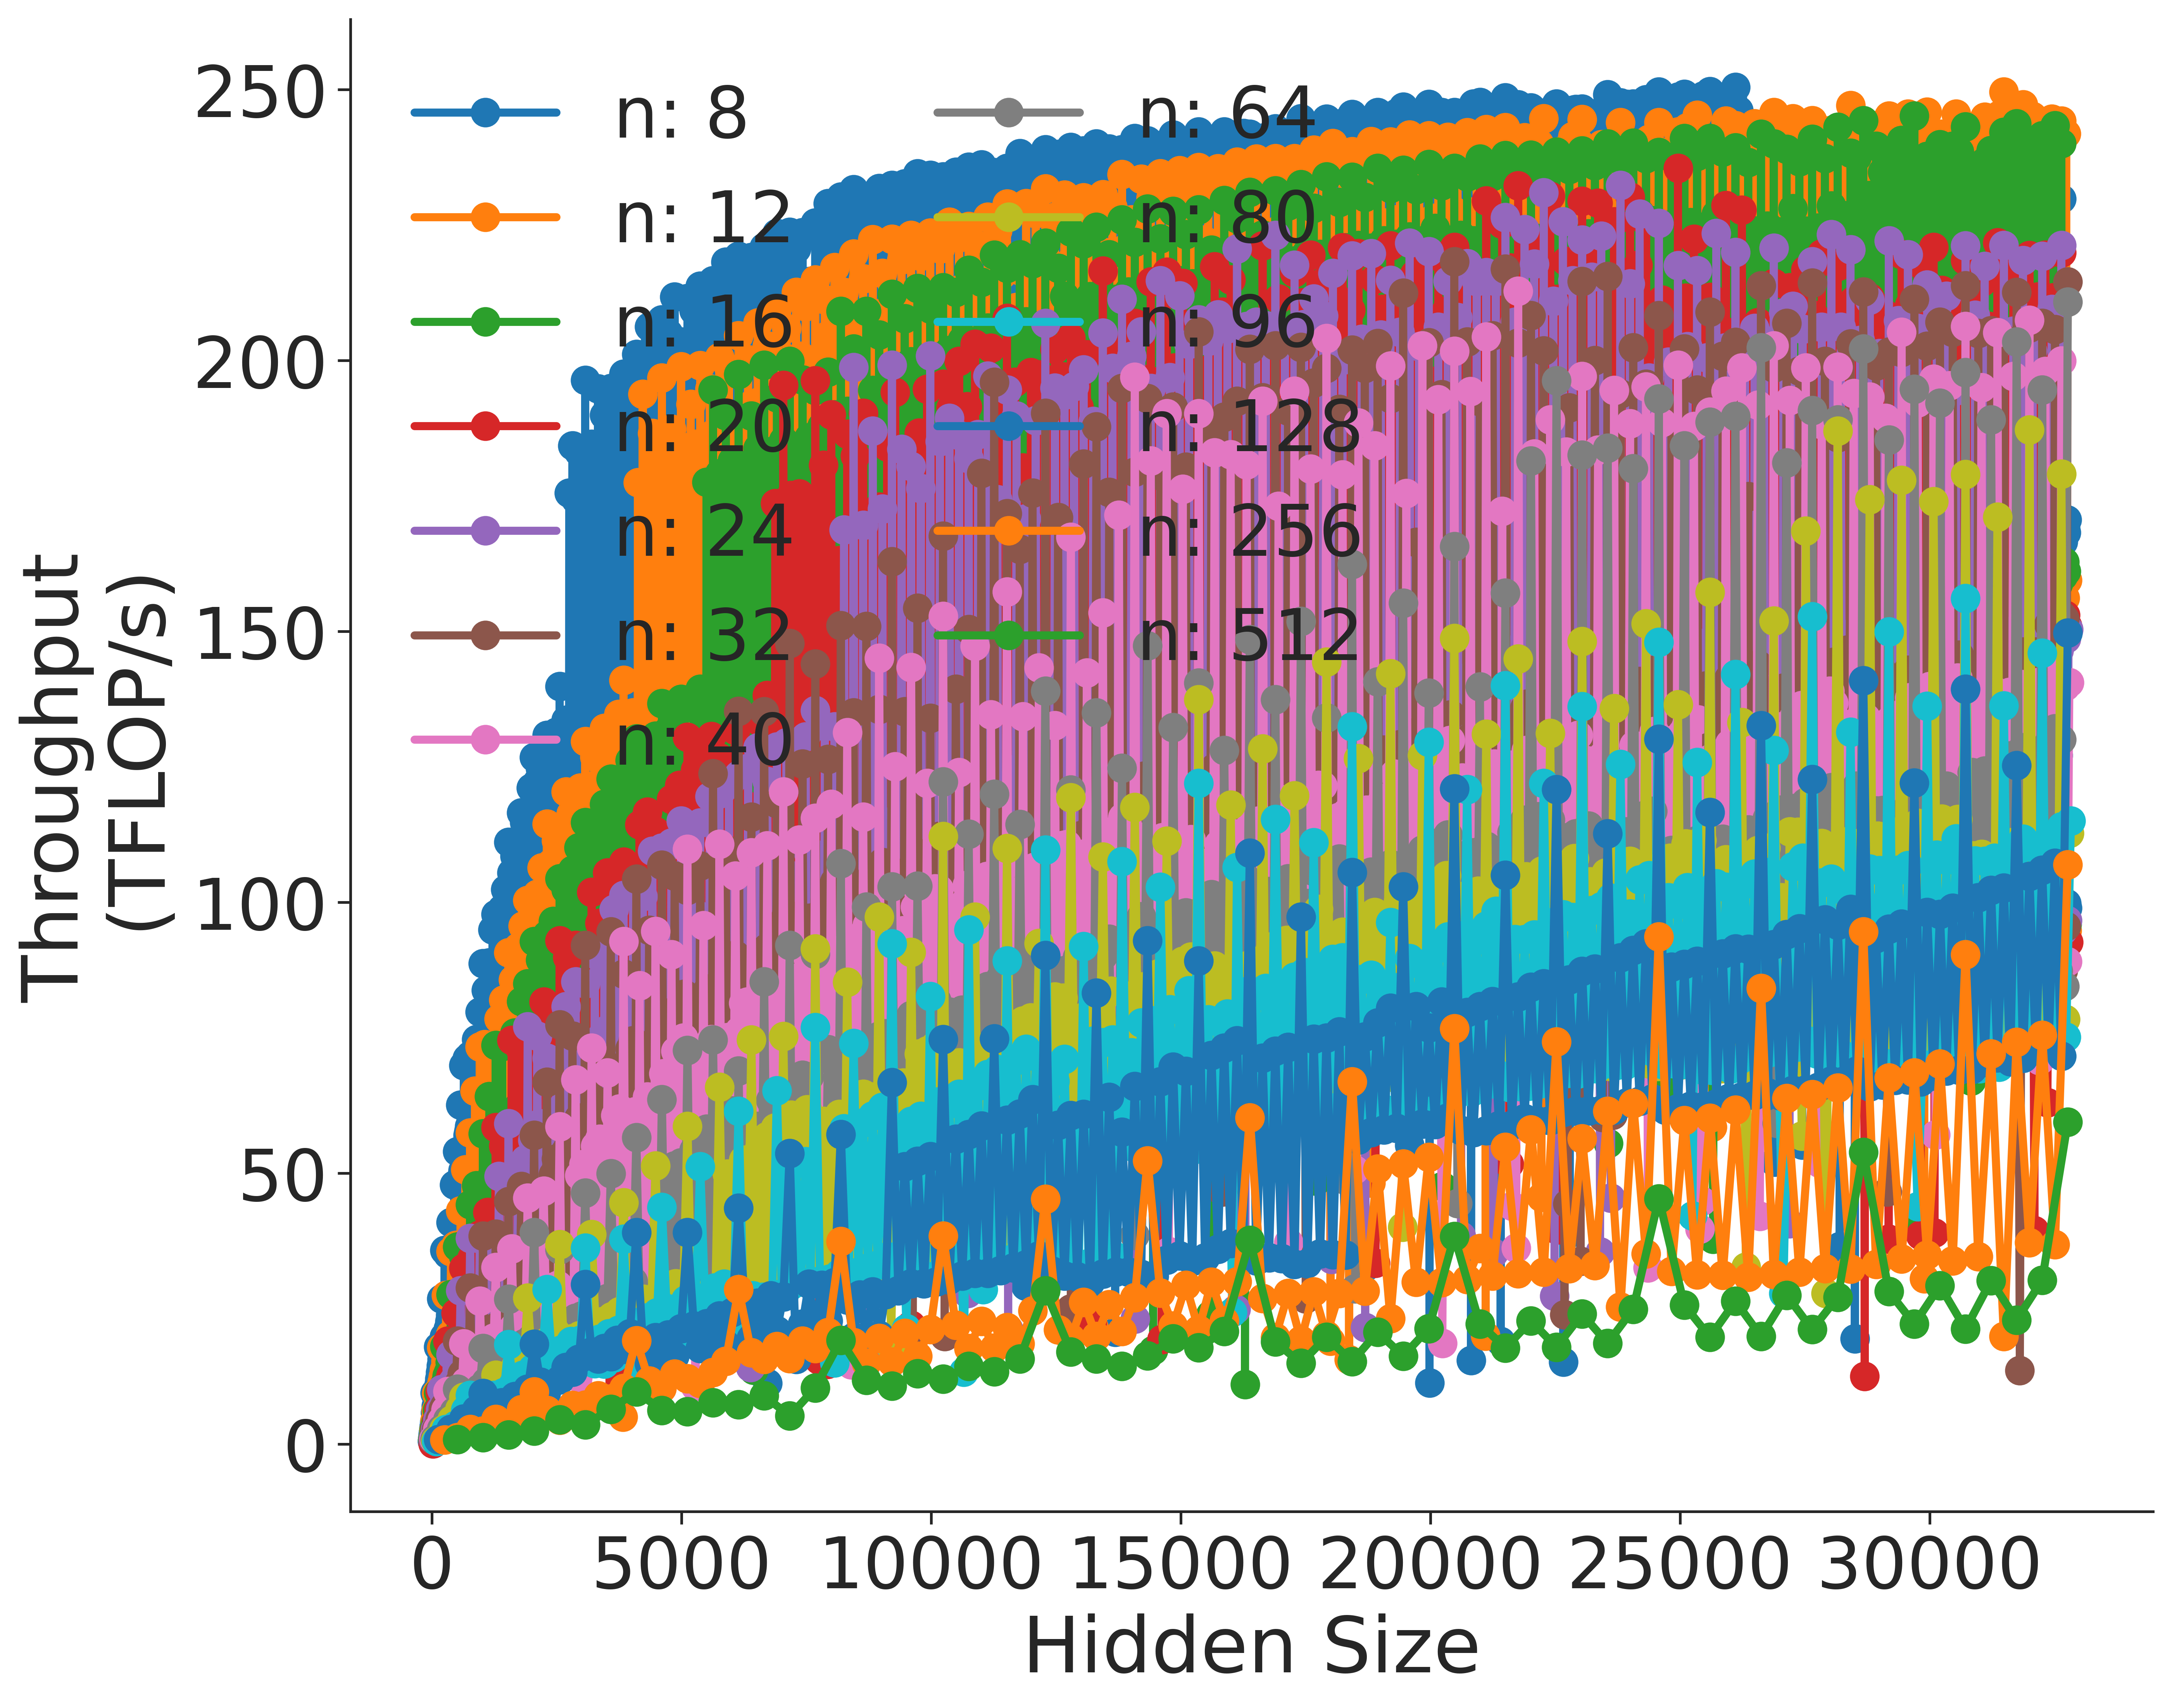

In [16]:
plot_hidden_sweep(read_logfile("results/3d_plot.out"),"attention_key_query_prob","title")

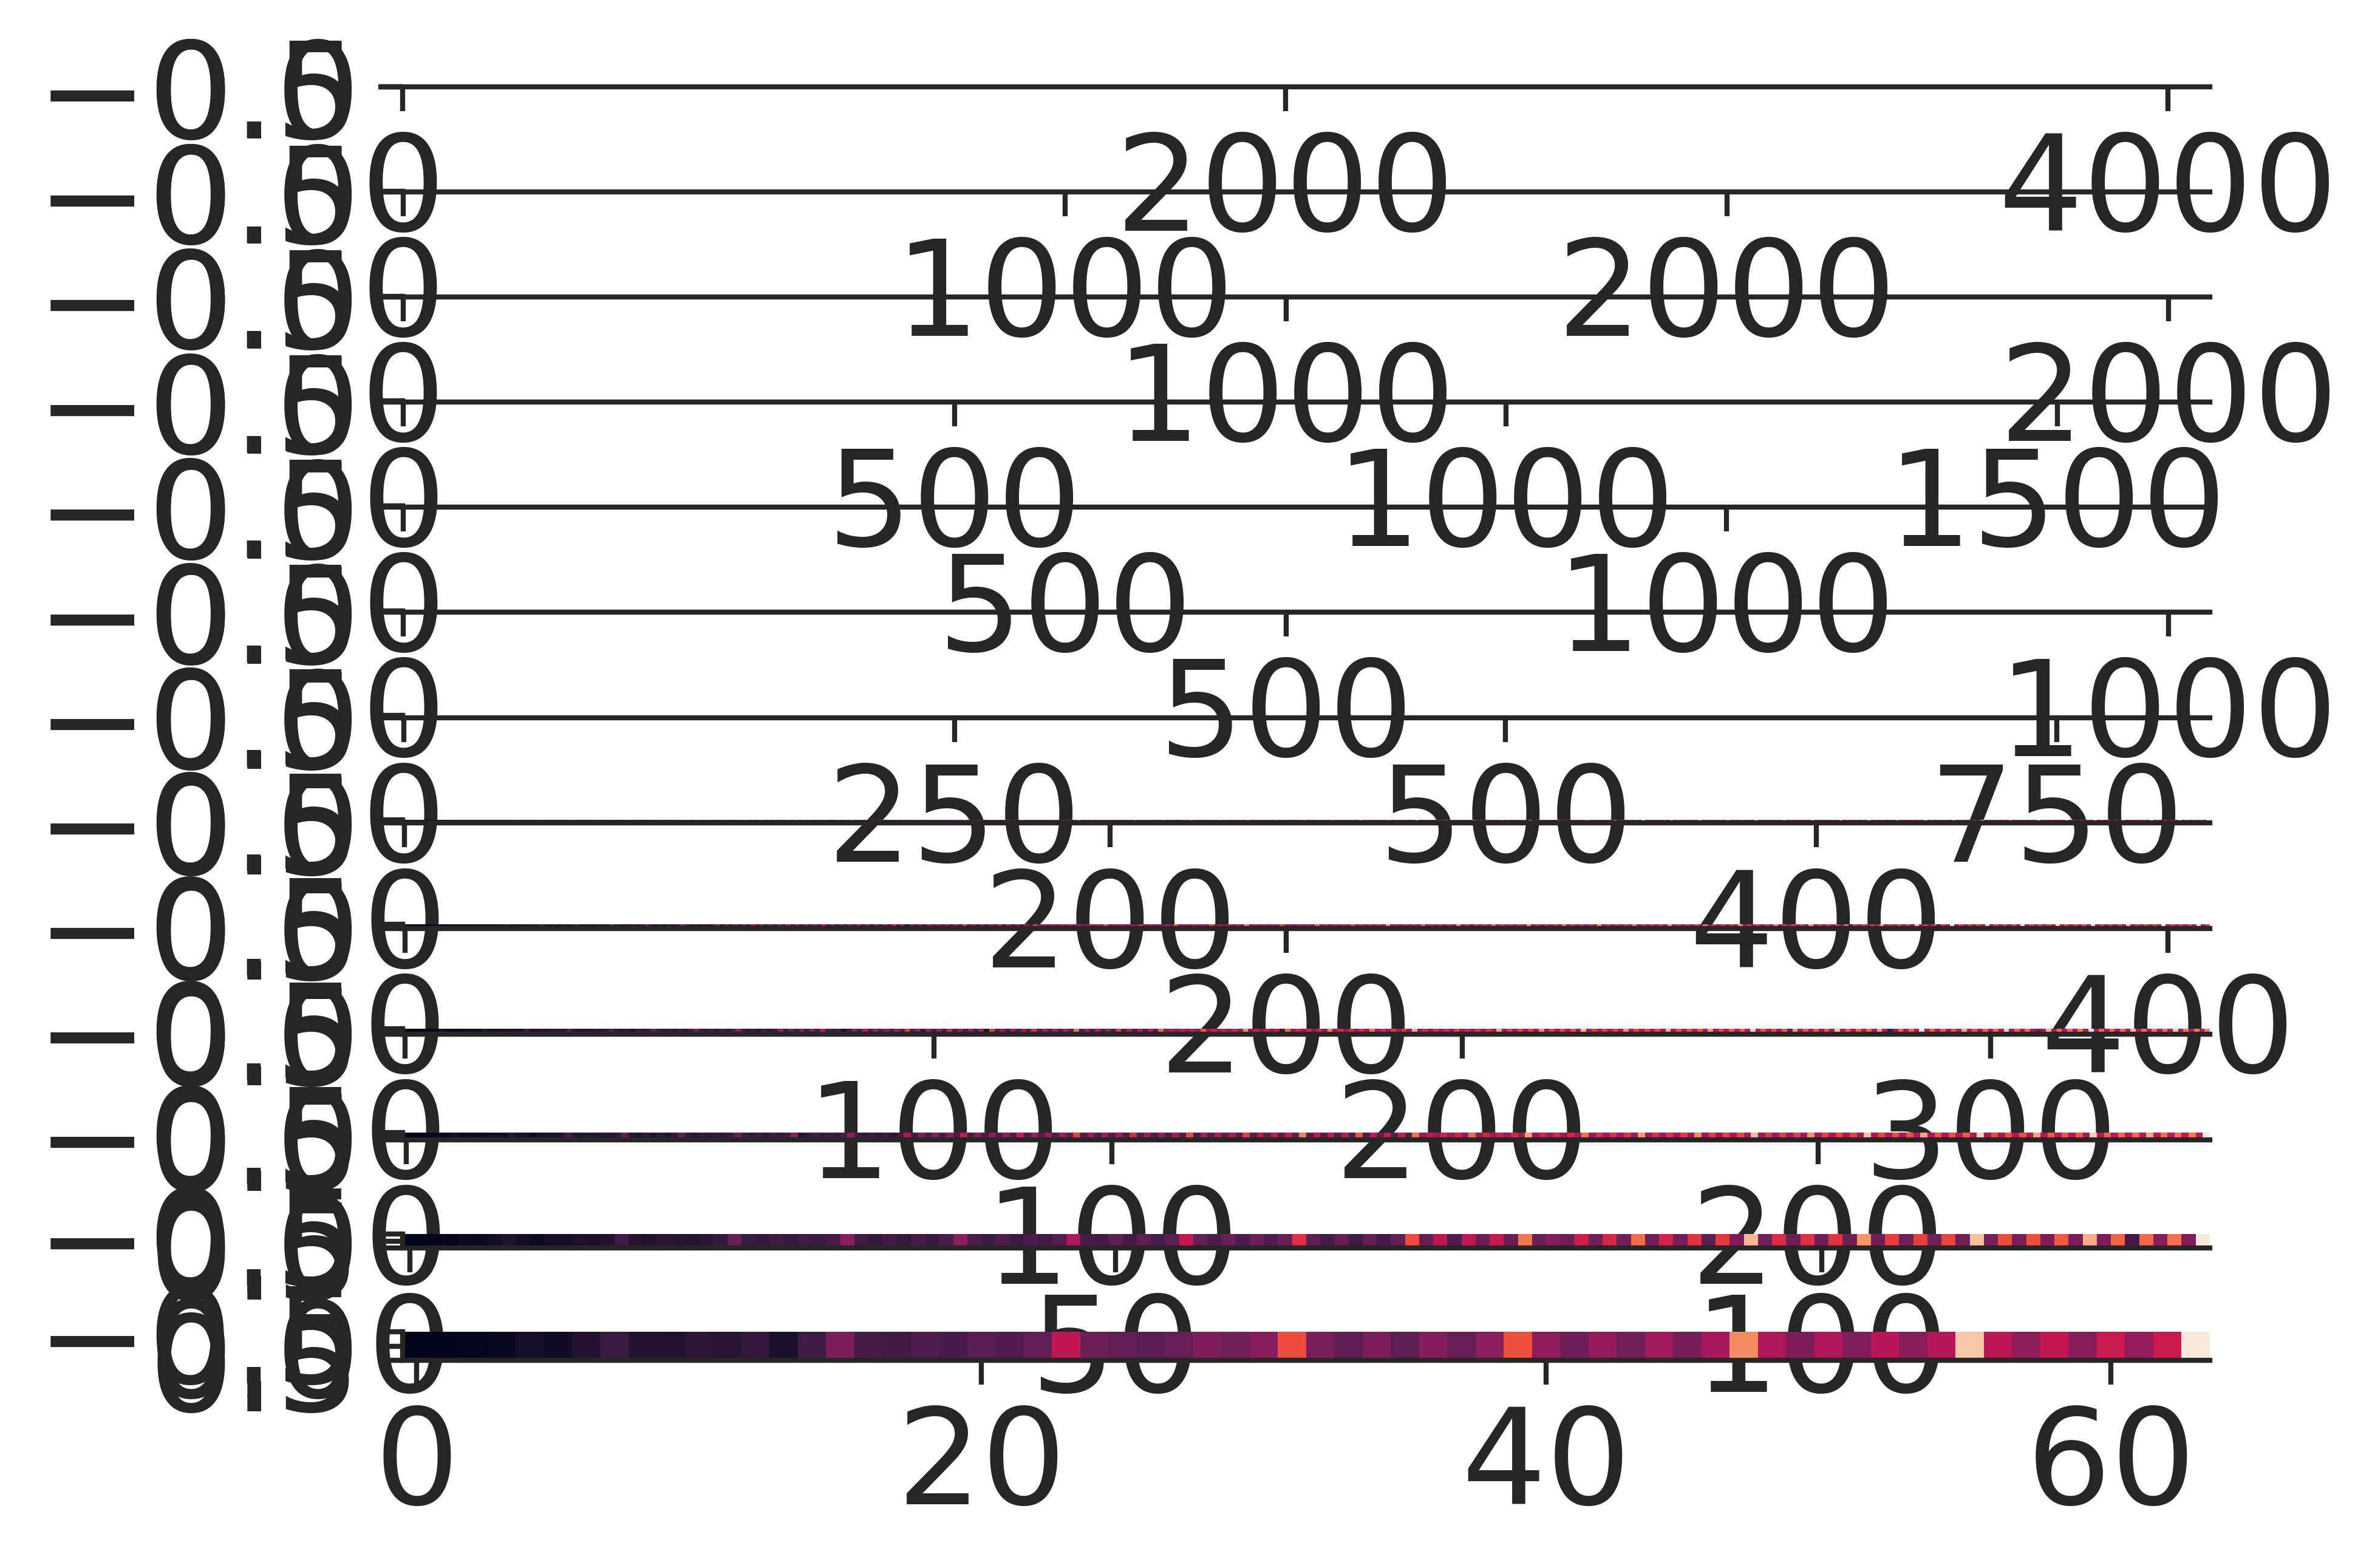

In [17]:
plot_hidden_sweep_3d(read_logfile("results/3d_plot.out"),"attention_key_query_prob","title")